In [1]:
import pandas as pd
import seaborn as sns
import pdb
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
#load esg dataset
label_address = 'drive/My Drive/ZENGG.csv'

df = pd.read_csv(label_address)

1. Define the Stock Universe

In [117]:
#get stock data
!pip install yfinance
import yfinance as yf
stock_list = df['Ticker'].unique().tolist()
stock_data = yf.download(stock_list, start="2017-07-27", end="2020-05-23")

[*********************100%***********************]  801 of 801 completed

318 Failed downloads:
- B5A: No data found, symbol may be delisted
- 3076: No data found, symbol may be delisted
- AUZ: No data found for this date range, symbol may be delisted
- 1288: No data found, symbol may be delisted
- AQI: No data found for this date range, symbol may be delisted
- 5201: No data found, symbol may be delisted
- 9783: No data found, symbol may be delisted
- AXO: No data found, symbol may be delisted
- AUQ: No data found for this date range, symbol may be delisted
- 3529: No data found, symbol may be delisted
- 2886: No data found, symbol may be delisted
- 3011: No data found, symbol may be delisted
- 2600: No data found, symbol may be delisted
- 1045: No data found, symbol may be delisted
- ATQT: No data found, symbol may be delisted
- BLTG: No data found, symbol may be delisted
- 4955: No data found, symbol may be delisted
- 105: No data found, symbol may be delisted
- ADOM: No data found,

In [120]:
#Preprocessing
returns = stock_data.iloc[1:,:].dropna(axis=1)
returns = returns['Adj Close']
return1 = returns
return2 = return1
result_esg_df = df
result_esg_df['Controversy Score'] = df['ESG_Mean']

In [39]:
result_esg_df = result_esg_df.groupby('Ticker').mean().drop('Unnamed: 0', axis=1).round(1)
result_esg_df.head(10)

,ESG_Mean,Controversy Score
Ticker,,
104,0.1,0.1
1045,-0.0,-0.0
105,-0.3,-0.3
1060,0.2,0.2
1120,1.1,1.1
1194,-0.1,-0.1
1288,-0.4,-0.4
1299,0.1,0.1
1338,-0.1,-0.1


Find Candidate Pairs

In [143]:
#PCA and classify stocks into clusters. Within clusters, we then look for strong mean-reverting pair relationships.
#PCA Decomposition and DBSCAN Clustering
N_PRIN_COMPONENTS = 15
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)


PCA(n_components=15)

In [144]:
pca.components_.T.shape

(420, 15)

In [145]:
X = np.hstack(
    (pca.components_.T,
     result_esg_df['Controversy Score'][returns.columns].values[:, np.newaxis])
)
print (X.shape)

(420, 16)


In [146]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print ("Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2))

Total pairs possible in universe: 87990 


In [205]:
X = preprocessing.StandardScaler().fit_transform(X)
# clf = DBSCAN(eps=1.9, min_samples=3)
clf = DBSCAN(eps=0.25, min_samples=2)
print (clf)
clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nClusters discovered: %d" % n_clusters_)
clustered = clf.labels_

DBSCAN(eps=0.25, min_samples=2)

Clusters discovered: 16


In [190]:
returns = return1

In [206]:
#Find Clusters
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]
CLUSTER_SIZE_LIMIT = 5000
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 16
Pairs to evaluate: 1800


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


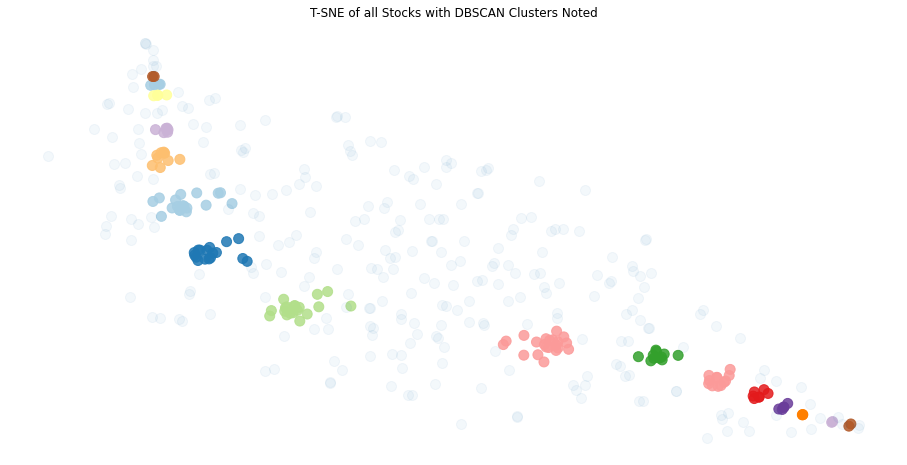

In [207]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
# plt.figure(1, facecolor='white')
plt.figure(figsize=(16, 8), facecolor='white')
plt.clf()
plt.axis('off')
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)
plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

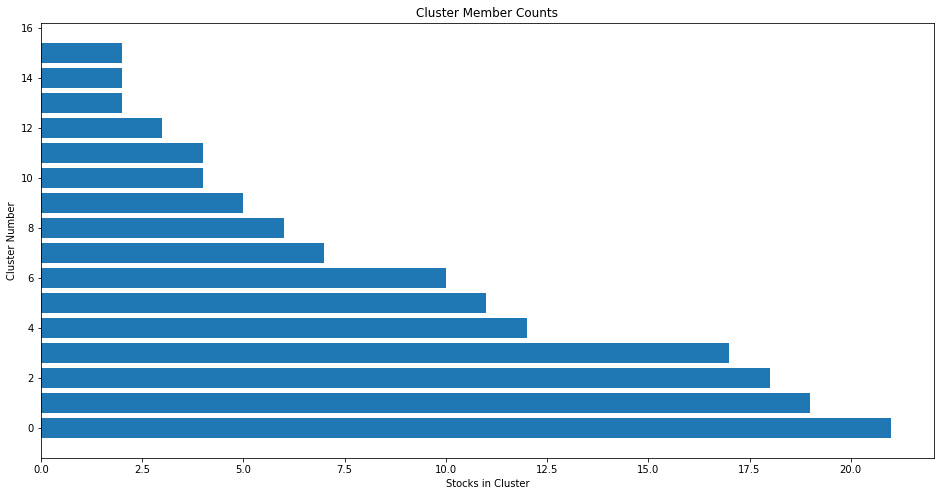

In [208]:
plt.figure(figsize=(16, 8))
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

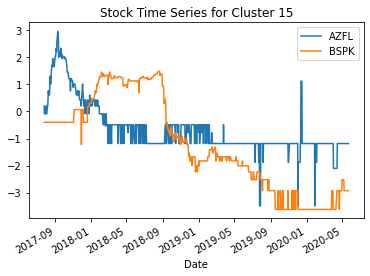

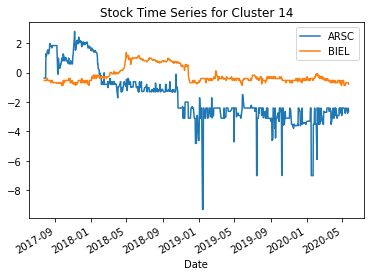

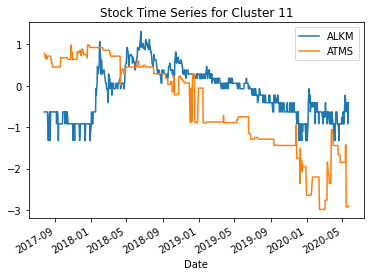

In [209]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()
# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]
# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(returns[tickers].mean())
    data = np.log(returns[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

In [210]:
which_cluster = clustered_series.loc['ACRX']
clustered_series[clustered_series == which_cluster]

ACRX     8
ADMP     8
AFPW     8
AGEN     8
ALIF     8
AMFL     8
ANLDF    8
ANTH     8
ATDRY    8
GNOW     8
dtype: int64

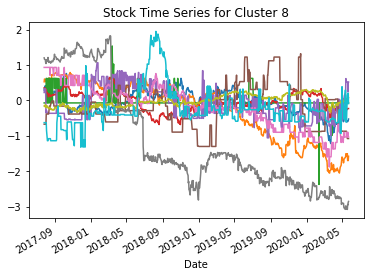

In [211]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(returns[tickers].mean())
data = np.log(returns[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster)

Validate the cointegration relationships and find stock pairs

In [197]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        returns[tickers].dropna()
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [218]:
pairs

[('ABBY', 'ACUS'),
 ('ABBY', 'AFTM'),
 ('ABBY', 'AHIX'),
 ('ABBY', 'AKRYY'),
 ('ABBY', 'AMMJ'),
 ('ABBY', 'AMSA'),
 ('ABBY', 'ARC'),
 ('ABBY', 'ARTH'),
 ('ABBY', 'ASFZ'),
 ('ABBY', 'ATGN'),
 ('ABBY', 'ATYM'),
 ('ABBY', 'AUOTY'),
 ('ABBY', 'AVNW'),
 ('ABBY', 'AWGL'),
 ('ABBY', 'AXU'),
 ('ABBY', 'BKCC'),
 ('ABBY', 'BRBMF'),
 ('ABBY', 'BRN'),
 ('ABBY', 'JALA'),
 ('ACUS', 'AFTM'),
 ('ACUS', 'AHIX'),
 ('ACUS', 'AKRYY'),
 ('ACUS', 'AMMJ'),
 ('ACUS', 'AMSA'),
 ('ACUS', 'ARC'),
 ('ACUS', 'ARTH'),
 ('ACUS', 'ASFZ'),
 ('ACUS', 'ATGN'),
 ('ACUS', 'ATYM'),
 ('ACUS', 'AUOTY'),
 ('ACUS', 'AVNW'),
 ('ACUS', 'AWGL'),
 ('ACUS', 'AXU'),
 ('ACUS', 'BKCC'),
 ('ACUS', 'BMSPF'),
 ('ACUS', 'BRBMF'),
 ('ACUS', 'BRN'),
 ('ACUS', 'JALA'),
 ('AHIX', 'BKCC'),
 ('AHIX', 'BMSPF'),
 ('AKRYY', 'BKCC'),
 ('AMSA', 'ARC'),
 ('AMSA', 'ARTH'),
 ('AMSA', 'ASFZ'),
 ('AMSA', 'ATGN'),
 ('AMSA', 'ATYM'),
 ('AMSA', 'AUOTY'),
 ('AMSA', 'AVNW'),
 ('AMSA', 'AWGL'),
 ('AMSA', 'AXU'),
 ('AMSA', 'BKCC'),
 ('AMSA', 'BMSPF'),
 ('AMSA',

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


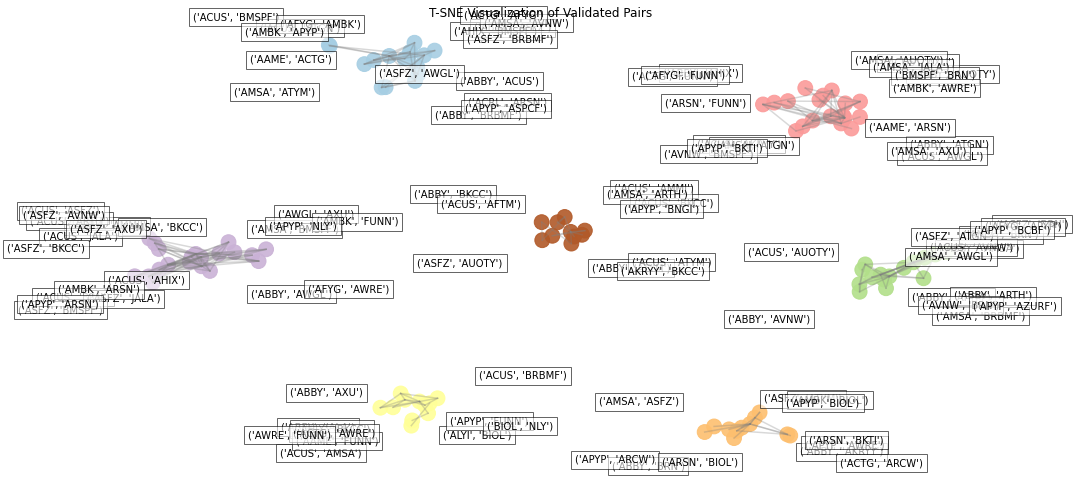

In [176]:
#Pair Visualization
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)
# plt.figure(1, facecolor='white')
plt.figure(figsize=(16, 8), facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[1]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values.ravel(), cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs')
# Add the participant names as text labels for each point
for index, (x_pos, y_pos, label) in enumerate(zip(X_tsne[:, 0], X_tsne[:, 1], pairs)):
    dx = x_pos - X_tsne[:, 0]
    dx[index] = 1
    dy = y_pos - X_tsne[:, 1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x_pos = x_pos + 5
    else:
        horizontalalignment = 'right'
        x_pos = x_pos - 5
    if this_dy > 0:
        verticalalignment = 'bottom'
        y_pos = y_pos + 5
    else:
        verticalalignment = 'top'
        y_pos = y_pos - 5
    
    plt.text(x_pos, y_pos, label, size=10,
         horizontalalignment=horizontalalignment,
         verticalalignment=verticalalignment,
         bbox=dict(facecolor='w',
                   alpha=.6))
# Show the plot
plt.show()

In [219]:
stock_data = returns
symbol_one = 'AATV'
symbol_two =  'MN'
stock_data = stock_data[[symbol_one,symbol_two]]
stock_data.index.name = 'Date'
stock_data

,AATV,MN
Date,,
2017-07-27,0.560,3.411826
2017-07-28,0.560,3.289975
2017-07-31,0.560,3.289975
2017-08-01,0.560,3.168124
2017-08-02,0.560,3.289975
...,...,...
2020-05-18,0.219,2.619039
2020-05-19,0.219,2.520207
2020-05-20,0.181,2.658571


In [225]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)
stock1_name, stock2_name = symbol_one,symbol_two
orig_data = stock_data.iloc[550:,]
data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [227]:
data

,AATV,MN
Date,,
2019-10-03 00:00:00,NaN,NaN
2019-10-04 00:00:00,0.000,0.047064
2019-10-07 00:00:00,0.000,0.075303
2019-10-08 00:00:00,0.000,0.075303
2019-10-09 00:00:00,0.000,0.094128
2019-10-10 00:00:00,0.000,0.075303
2019-10-11 00:00:00,0.000,0.122890
2019-10-14 00:00:00,-0.140,0.151754
2019-10-15 00:00:00,0.070,0.113268


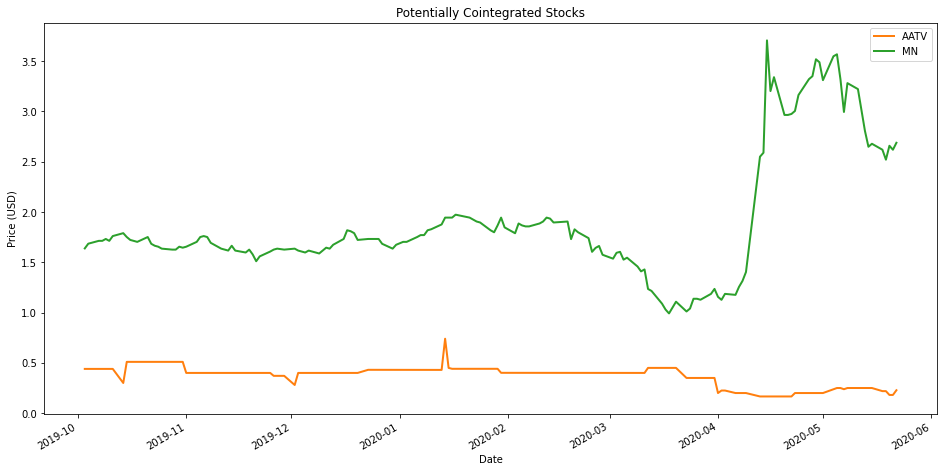

In [221]:
plt.figure(figsize = (16,8))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

We take a Bayesian approach to pairs trading using probabilistic programming, which is a form of Bayesian machine learning. Unlike simpler frequentist cointegration tests, our Bayesian approach allows us to monitor the relationship between a pair of equities over time, which allows us to follow pairs whose cointegration parameters change steadily or abruptly. When combined with a simple mean-reversion trading algorithm, we demonstrate this to be a viable theoretical trading strategy, ready for further evaluation and risk management.

In [180]:
#Bayesian modeling
with pm.Model() as model:
    
    # inject external stock data
    stock1 = th.shared(data1)
    stock2 = th.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sd=beta_sigma,
                                 shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
# Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y',
                           mu=stock2_regression,
                           sd=sd,
                           observed=stock2)
with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    trace = pm.sample(2000,tune=1000,cores=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, beta_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 440 seconds.
The acceptance probability does not match the target. It is 0.9075203339927762, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 710 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.2728870466726083e-09, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0006772097019616243, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for 

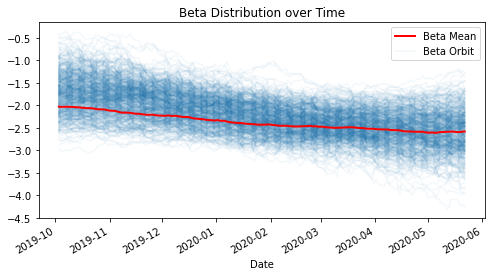

In [181]:
# 𝛽 distribution from the model over time
rolling_beta = trace[beta].T.mean(axis=1)
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)
for orbit in trace[beta][:500]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

In [228]:
rolling_beta

array([-2.02770171, -2.03297739, -2.0319379 , -2.02861355, -2.0341016 ,
       -2.03543535, -2.035031  , -2.04433909, -2.04455921, -2.05323897,
       -2.05302912, -2.05956669, -2.06194962, -2.06458357, -2.07111185,
       -2.07617491, -2.08590889, -2.09060135, -2.09045567, -2.09829323,
       -2.10935904, -2.11643445, -2.12309158, -2.13180053, -2.13912947,
       -2.15123226, -2.16138557, -2.16182567, -2.16483228, -2.16560436,
       -2.17381081, -2.1820895 , -2.18881862, -2.19137621, -2.20044696,
       -2.20239262, -2.20948304, -2.20770027, -2.20791612, -2.21874692,
       -2.22491483, -2.23206324, -2.2311582 , -2.22424474, -2.22285487,
       -2.23532161, -2.23094363, -2.24237521, -2.24822769, -2.2500406 ,
       -2.25825852, -2.25921106, -2.26581482, -2.27811019, -2.28986484,
       -2.29353129, -2.30384095, -2.30510394, -2.31978102, -2.32292456,
       -2.33249512, -2.33698119, -2.3264707 , -2.34056243, -2.34470696,
       -2.36091743, -2.36803079, -2.3707602 , -2.37956904, -2.39

In [242]:
#Test
data1 = data['AATV'].ffill().fillna(0).values
data2 = data['MN'].ffill().fillna(0).values
# initial signal rebalance
fixed_beta = rolling_beta[15]
signal = fixed_beta*data1 - data2
smoothed_signal = pd.Series(signal).rolling(15).mean()
d_smoothed_signal = smoothed_signal.diff()
trading = "not"
trading_start = 0
leverage = 0*data.copy()
for i in range(15,data1.shape[0]):
      leverage.iloc[i,:] = leverage.iloc[i-1,:]
      if trading=="not":
        fixed_beta = rolling_beta[i]
        signal = fixed_beta*data1 - data2
        smoothed_signal = pd.Series(signal).rolling(15).mean()
        d_smoothed_signal = smoothed_signal.diff()
      if smoothed_signal[i]>0 and d_smoothed_signal[i]<0:
        leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
        leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)
        trading = "short"
        trading_start = smoothed_signal[i]
leverage

,AATV,MN
Date,,
2019-10-03 00:00:00,NaN,NaN
2019-10-04 00:00:00,0.000000,0.000000
2019-10-07 00:00:00,0.000000,0.000000
2019-10-08 00:00:00,0.000000,0.000000
2019-10-09 00:00:00,0.000000,0.000000
2019-10-10 00:00:00,0.000000,0.000000
2019-10-11 00:00:00,0.000000,0.000000
2019-10-14 00:00:00,-0.000000,0.000000
2019-10-15 00:00:00,0.000000,0.000000


# Trading Strategies
Define a “signal”, which should mean-revert to zero if 𝛽 remains relatively stationary.
Define a “smoothed signal”, a 15-day moving average of the “signal”.
If we are not trading…
Update 𝛽 so that it does not remain fixed while we aren’t trading.
If the smoothed signal is above zero and moving downward, short our portfolio.
If the smoothed signal is below zero and moving upward, go long on our portfolio.
If we are trading long…
If the smoothed signal goes below its start value, close the trade; we may be diverging from the mean.
If the smoothed signal rises through the zero line, we’ve reached the mean. Close the trade.
If we are trading short…
If the smoothed signal goes above its start value, close the trade; we may be diverging from the mean.
If the smoothed signal falls through the zero line, we’ve reached the mean. Close the trade.

In [243]:
def getStrategyPortfolioWeights(rolling_beta,stock_name1,stock_name2,data,smoothing_window=1):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values
# initial signal rebalance
    fixed_beta = rolling_beta[smoothing_window]
    signal = fixed_beta*data1 - data2
    smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    for i in range(smoothing_window,data1.shape[0]):
      leverage.iloc[i,:] = leverage.iloc[i-1,:]
      if trading=="not":
# dynamically rebalance the signal when not trading
        fixed_beta = rolling_beta[i]
        signal = fixed_beta*data1 - data2
        smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
        d_smoothed_signal = smoothed_signal.diff()
      if smoothed_signal[i]>0 and d_smoothed_signal[i]<0:
        leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
        leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)
        trading = "short"
        trading_start = smoothed_signal[i]

      elif smoothed_signal[i]<0 and d_smoothed_signal[i]>0:
        fixed_beta = rolling_beta[i]
        leverage.iloc[i,0] = fixed_beta / (abs(fixed_beta)+1)
        leverage.iloc[i,1] = -1 / (abs(fixed_beta)+1)
        trading = "long"
        trading_start = smoothed_signal[i]

      elif trading=="long":
        if smoothed_signal[i] < trading_start:
          leverage.iloc[i,0] = 0
          leverage.iloc[i,1] = 0
          trading = "not"
# a successful trade
        if smoothed_signal[i]>0:
          leverage.iloc[i,0] = 0
          leverage.iloc[i,1] = 0
          trading = "not"

      elif trading=="short":
# a failed trade
        if smoothed_signal[i] > trading_start:
          leverage.iloc[i,0] = 0
          leverage.iloc[i,1] = 0
          trading = "not"
# a successful trade
        if smoothed_signal[i]<0:
          leverage.iloc[i,0] = 0
          leverage.iloc[i,1] = 0
          trading = "not"
      else:
        leverage.iloc[i,0] = 0
        leverage.iloc[i,1] = 0
                
    return leverage

In [244]:

portfolioWeights = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name,data).fillna(0)

In [245]:
portfolioWeights

,AATV,MN
Date,,
2019-10-03 00:00:00,0.000000,0.000000
2019-10-04 00:00:00,0.000000,0.000000
2019-10-07 00:00:00,0.000000,0.000000
2019-10-08 00:00:00,0.000000,0.000000
2019-10-09 00:00:00,0.000000,0.000000
2019-10-10 00:00:00,-0.670558,-0.329442
2019-10-11 00:00:00,0.000000,0.000000
2019-10-14 00:00:00,0.000000,0.000000
2019-10-15 00:00:00,0.000000,0.000000


Backtesting & Performance in Market Drops

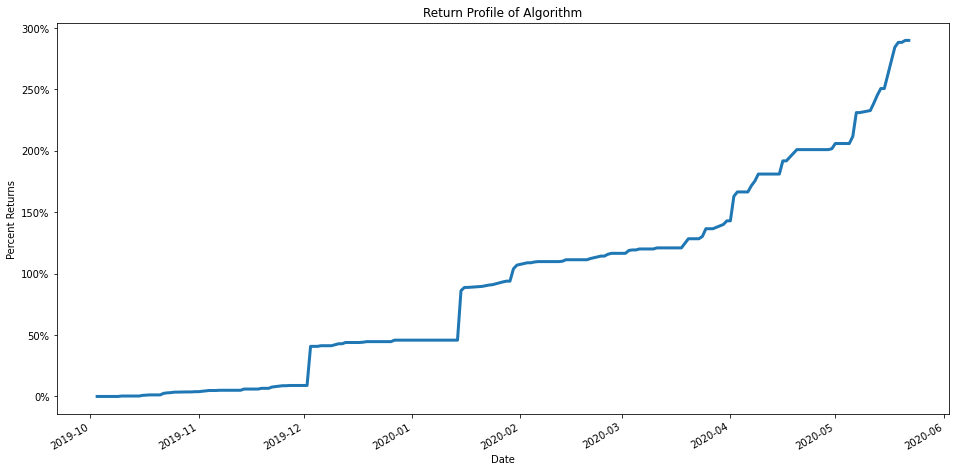

In [246]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta,stock1_name, stock2_name,data).fillna(0)
def backtest(pricingDF,leverageDF,start_cash):
    """Backtests pricing based on some given set of leverage. Leverage works such that it happens "overnight",
    so leverage for "today" is applied to yesterday's close price. This algo can handle NaNs in pricing data
    before a stock exists, but ffill() should be used for NaNs that occur after the stock has existed, even
    if that stock ceases to exist later."""
    
    pricing = pricingDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    curr_price_div = np.zeros(pricing.shape[1])
    
    for t in range(1,pricing.shape[0]):
        
        if np.any(leverage[t]!=leverage[t-1]):
# handle non-existent stock values
            curr_price[:] = pricing[t-1]     # you can multiply with this one
            curr_price[np.isnan(curr_price)] = 0
            trading_allowed = (curr_price!=0)
            curr_price_div[:] = curr_price    # you can divide with this one
            curr_price_div[~trading_allowed] = 1
            
            # determine new positions (warning: leverage to non-trading_allowed stocks is just lost)
            portfolio_value = (shares[t-1]*curr_price).sum()+cash[t-1]
            target_shares = trading_allowed * (portfolio_value*leverage[t]) // curr_price_div
            
            # rebalance
            shares[t] = target_shares
            cash[t] = cash[t-1] - ((shares[t]-shares[t-1])*curr_price).sum()
            
        else:
            
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
    
    returns = (shares*np.nan_to_num(pricing)).sum(axis=1)+cash
    pct_returns = (returns-start_cash)/start_cash
    return (
        pd.DataFrame( shares, index=pricingDF.index, columns=pricingDF.columns ),
        pd.Series( cash, index=pricingDF.index ),
        pd.Series( pct_returns, index=pricingDF.index)
    )
shares, cash, returns = backtest(orig_data, portfolioWeights, 1e6 )
plt.figure(figsize = (16,8))
ax = plt.gca()
plt.title("Return Profile of Algorithm")
plt.ylabel("Percent Returns")
returns.plot(ax=ax,linewidth=3)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()